# Previsão da nota de Matemática do ENEM 2016

## Biblioteca

In [161]:
!pip install category_encoders

In [162]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style(style='darkgrid')

from scipy import stats
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from category_encoders import OrdinalEncoder 

from sklearn.feature_selection import SelectKBest, f_classif

from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import r2_score, mean_squared_error, accuracy_score, plot_confusion_matrix
# from sklearn.linear_model import Ridge, Lasso  

from sklearn.compose import ColumnTransformer, TransformedTargetRegressor
from sklearn.pipeline import Pipeline

import pickle as pk


In [163]:
df = pd.read_csv('https://raw.githubusercontent.com/felipedidier/prevendo-notas-enem2016/master/train.csv',encoding='utf-8-sig')

In [164]:
df.head()

,Unnamed: 0,NU_INSCRICAO,NU_ANO,CO_MUNICIPIO_RESIDENCIA,NO_MUNICIPIO_RESIDENCIA,CO_UF_RESIDENCIA,SG_UF_RESIDENCIA,NU_IDADE,TP_SEXO,TP_ESTADO_CIVIL,...,Q041,Q042,Q043,Q044,Q045,Q046,Q047,Q048,Q049,Q050
0,1,ed50e8aaa58e7a806c337585efee9ca41f1eb1ad,2016,4314902,Porto Alegre,43,RS,24,M,0.0,...,5.0,A,A,A,A,A,A,A,B,D
1,2,2c3acac4b33ec2b195d77e7c04a2d75727fad723,2016,2304707,Granja,23,CE,17,F,0.0,...,NaN,A,A,C,A,B,A,A,C,A
2,3,f4545f8ccb9ff5c8aad7d32951b3f251a26e6568,2016,2304400,Fortaleza,23,CE,21,F,0.0,...,NaN,A,A,A,A,C,A,A,B,A
3,4,3d6ec248fef899c414e77f82d5c6d2bffbeaf7fe,2016,3304557,Rio de Janeiro,33,RJ,25,F,0.0,...,5.0,C,A,A,A,A,D,A,A,A
4,5,bf896ac8d3ecadd6dba1dfbf50110afcbf5d3268,2016,1302603,Manaus,13,AM,28,M,0.0,...,NaN,A,A,A,A,A,A,A,A,A


In [165]:
df.shape

(13730, 167)

## Análise Exploratória
Foi realizado um primeiro filtro das features existentes na base a partir de análise manual. As features selecionadas serão analisadas mais a fundo para compreensão dos dados.

In [166]:
selected_feat = ['NU_IDADE', 'SG_UF_RESIDENCIA', 'TP_SEXO', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO', 'TP_ESCOLA', 'IN_TREINEIRO', 'IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF', 'IN_GESTANTE', 'IN_LACTANTE', 'IN_IDOSO', 'TP_PRESENCA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC', 'NU_NOTA_MT', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q042', 'Q043', 'Q045', 'Q047', 'Q048']
print(f"{len(selected_feat)} features selecionadas")

56 features selecionadas


In [167]:
df = df[selected_feat]

In [168]:
df.head()

,NU_IDADE,SG_UF_RESIDENCIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,IN_BAIXA_VISAO,...,Q022,Q023,Q024,Q025,Q026,Q042,Q043,Q045,Q047,Q048
0,24,RS,M,0.0,1,1,1,1,0,0,...,C,A,A,A,C,A,A,A,A,A
1,17,CE,F,0.0,3,1,2,2,0,0,...,A,A,A,A,A,A,A,A,A,A
2,21,CE,F,0.0,3,1,3,1,0,0,...,B,A,A,A,A,A,A,A,A,A
3,25,RJ,F,0.0,0,1,1,1,0,0,...,D,B,C,B,C,C,A,A,D,A
4,28,AM,M,0.0,2,1,1,1,0,0,...,B,A,A,A,B,A,A,A,A,A


In [169]:
df.shape

(13730, 56)

In [170]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 13730 entries, 0 to 13729
Data columns (total 56 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   NU_IDADE                 13730 non-null  int64  
 1   SG_UF_RESIDENCIA         13730 non-null  object 
 2   TP_SEXO                  13730 non-null  object 
 3   TP_ESTADO_CIVIL          13202 non-null  float64
 4   TP_COR_RACA              13730 non-null  int64  
 5   TP_NACIONALIDADE         13730 non-null  int64  
 6   TP_ST_CONCLUSAO          13730 non-null  int64  
 7   TP_ESCOLA                13730 non-null  int64  
 8   IN_TREINEIRO             13730 non-null  int64  
 9   IN_BAIXA_VISAO           13730 non-null  int64  
 10  IN_CEGUEIRA              13730 non-null  int64  
 11  IN_SURDEZ                13730 non-null  int64  
 12  IN_DEFICIENCIA_AUDITIVA  13730 non-null  int64  
 13  IN_SURDO_CEGUEIRA        13730 non-null  int64  
 14  IN_DEFICIENCIA_FISICA 

In [171]:
df.isna().sum()

NU_IDADE                      0
SG_UF_RESIDENCIA              0
TP_SEXO                       0
TP_ESTADO_CIVIL             528
TP_COR_RACA                   0
TP_NACIONALIDADE              0
TP_ST_CONCLUSAO               0
TP_ESCOLA                     0
IN_TREINEIRO                  0
IN_BAIXA_VISAO                0
IN_CEGUEIRA                   0
IN_SURDEZ                     0
IN_DEFICIENCIA_AUDITIVA       0
IN_SURDO_CEGUEIRA             0
IN_DEFICIENCIA_FISICA         0
IN_DEFICIENCIA_MENTAL         0
IN_DEFICIT_ATENCAO            0
IN_DISLEXIA                   0
IN_DISCALCULIA                0
IN_AUTISMO                    0
IN_VISAO_MONOCULAR            0
IN_OUTRA_DEF                  0
IN_GESTANTE                   0
IN_LACTANTE                   0
IN_IDOSO                      0
TP_PRESENCA_MT                0
NU_NOTA_CN                 3389
NU_NOTA_CH                 3389
NU_NOTA_LC                 3597
NU_NOTA_MT                 3597
Q006                          0
Q007    

### Tratamento de NU_NOTA_MT e TP_PRESENCA_MT

A feature TP_PRESENCA_MT indica a presença do participante na prova de matemática ou sua eliminação. Nesse caso, serão mantidos apenas os participantes que estiveram presentes na prova. As parcelas nulas de NU_NOTA_MT são decorrentes dos candidatos que não estiveram presentes na prova ou foram eliminados.

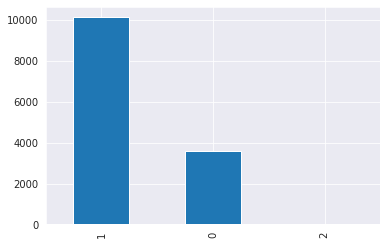

In [172]:
df['TP_PRESENCA_MT'].value_counts().plot.bar()
plt.show()

In [173]:
df['TP_PRESENCA_MT'].value_counts()

1    10133
0     3592
2        5
Name: TP_PRESENCA_MT, dtype: int64

In [174]:
df = df[df['TP_PRESENCA_MT']==1]

In [175]:
df = df.drop(columns='TP_PRESENCA_MT')

In [176]:
df = df[~df['NU_NOTA_CH'].isna()==True]

In [177]:
df.shape

(10097, 55)

### Tratamento de TP_ESTADO_CIVIL
Como não há justificativa para o não preenchimento desse campo, os dados nulos serão removidos.

In [178]:
df['TP_ESTADO_CIVIL'].value_counts()

0.0    9060
1.0     638
2.0      75
3.0       8
Name: TP_ESTADO_CIVIL, dtype: int64

In [179]:
df = df[df['TP_ESTADO_CIVIL'].isna()==False]

In [180]:
df.shape

(9781, 55)

### Tratamento de IN
As variáveis que remetem à uma deficiência física serão aglomeradas em uma mesma variável.

In [181]:
IN = ['IN_BAIXA_VISAO', 'IN_CEGUEIRA', 'IN_SURDEZ', 'IN_DEFICIENCIA_AUDITIVA', 'IN_SURDO_CEGUEIRA', 'IN_DEFICIENCIA_FISICA', 'IN_DEFICIENCIA_MENTAL', 'IN_DEFICIT_ATENCAO', 'IN_DISLEXIA', 'IN_DISCALCULIA', 'IN_AUTISMO', 'IN_VISAO_MONOCULAR', 'IN_OUTRA_DEF']

In [182]:
for i in IN:
  print(df[i].value_counts())

0    9770
1      11
Name: IN_BAIXA_VISAO, dtype: int64
0    9781
Name: IN_CEGUEIRA, dtype: int64
0    9777
1       4
Name: IN_SURDEZ, dtype: int64
0    9775
1       6
Name: IN_DEFICIENCIA_AUDITIVA, dtype: int64
0    9781
Name: IN_SURDO_CEGUEIRA, dtype: int64
0    9764
1      17
Name: IN_DEFICIENCIA_FISICA, dtype: int64
0    9779
1       2
Name: IN_DEFICIENCIA_MENTAL, dtype: int64
0    9770
1      11
Name: IN_DEFICIT_ATENCAO, dtype: int64
0    9780
1       1
Name: IN_DISLEXIA, dtype: int64
0    9780
1       1
Name: IN_DISCALCULIA, dtype: int64
0    9781
Name: IN_AUTISMO, dtype: int64
0    9776
1       5
Name: IN_VISAO_MONOCULAR, dtype: int64
0    9778
1       3
Name: IN_OUTRA_DEF, dtype: int64


In [183]:
df.drop(columns=IN, inplace=True)

In [184]:
df.shape

(9781, 42)

### Visualização dos dados

In [185]:
selected_feat_eda = list(df.columns)

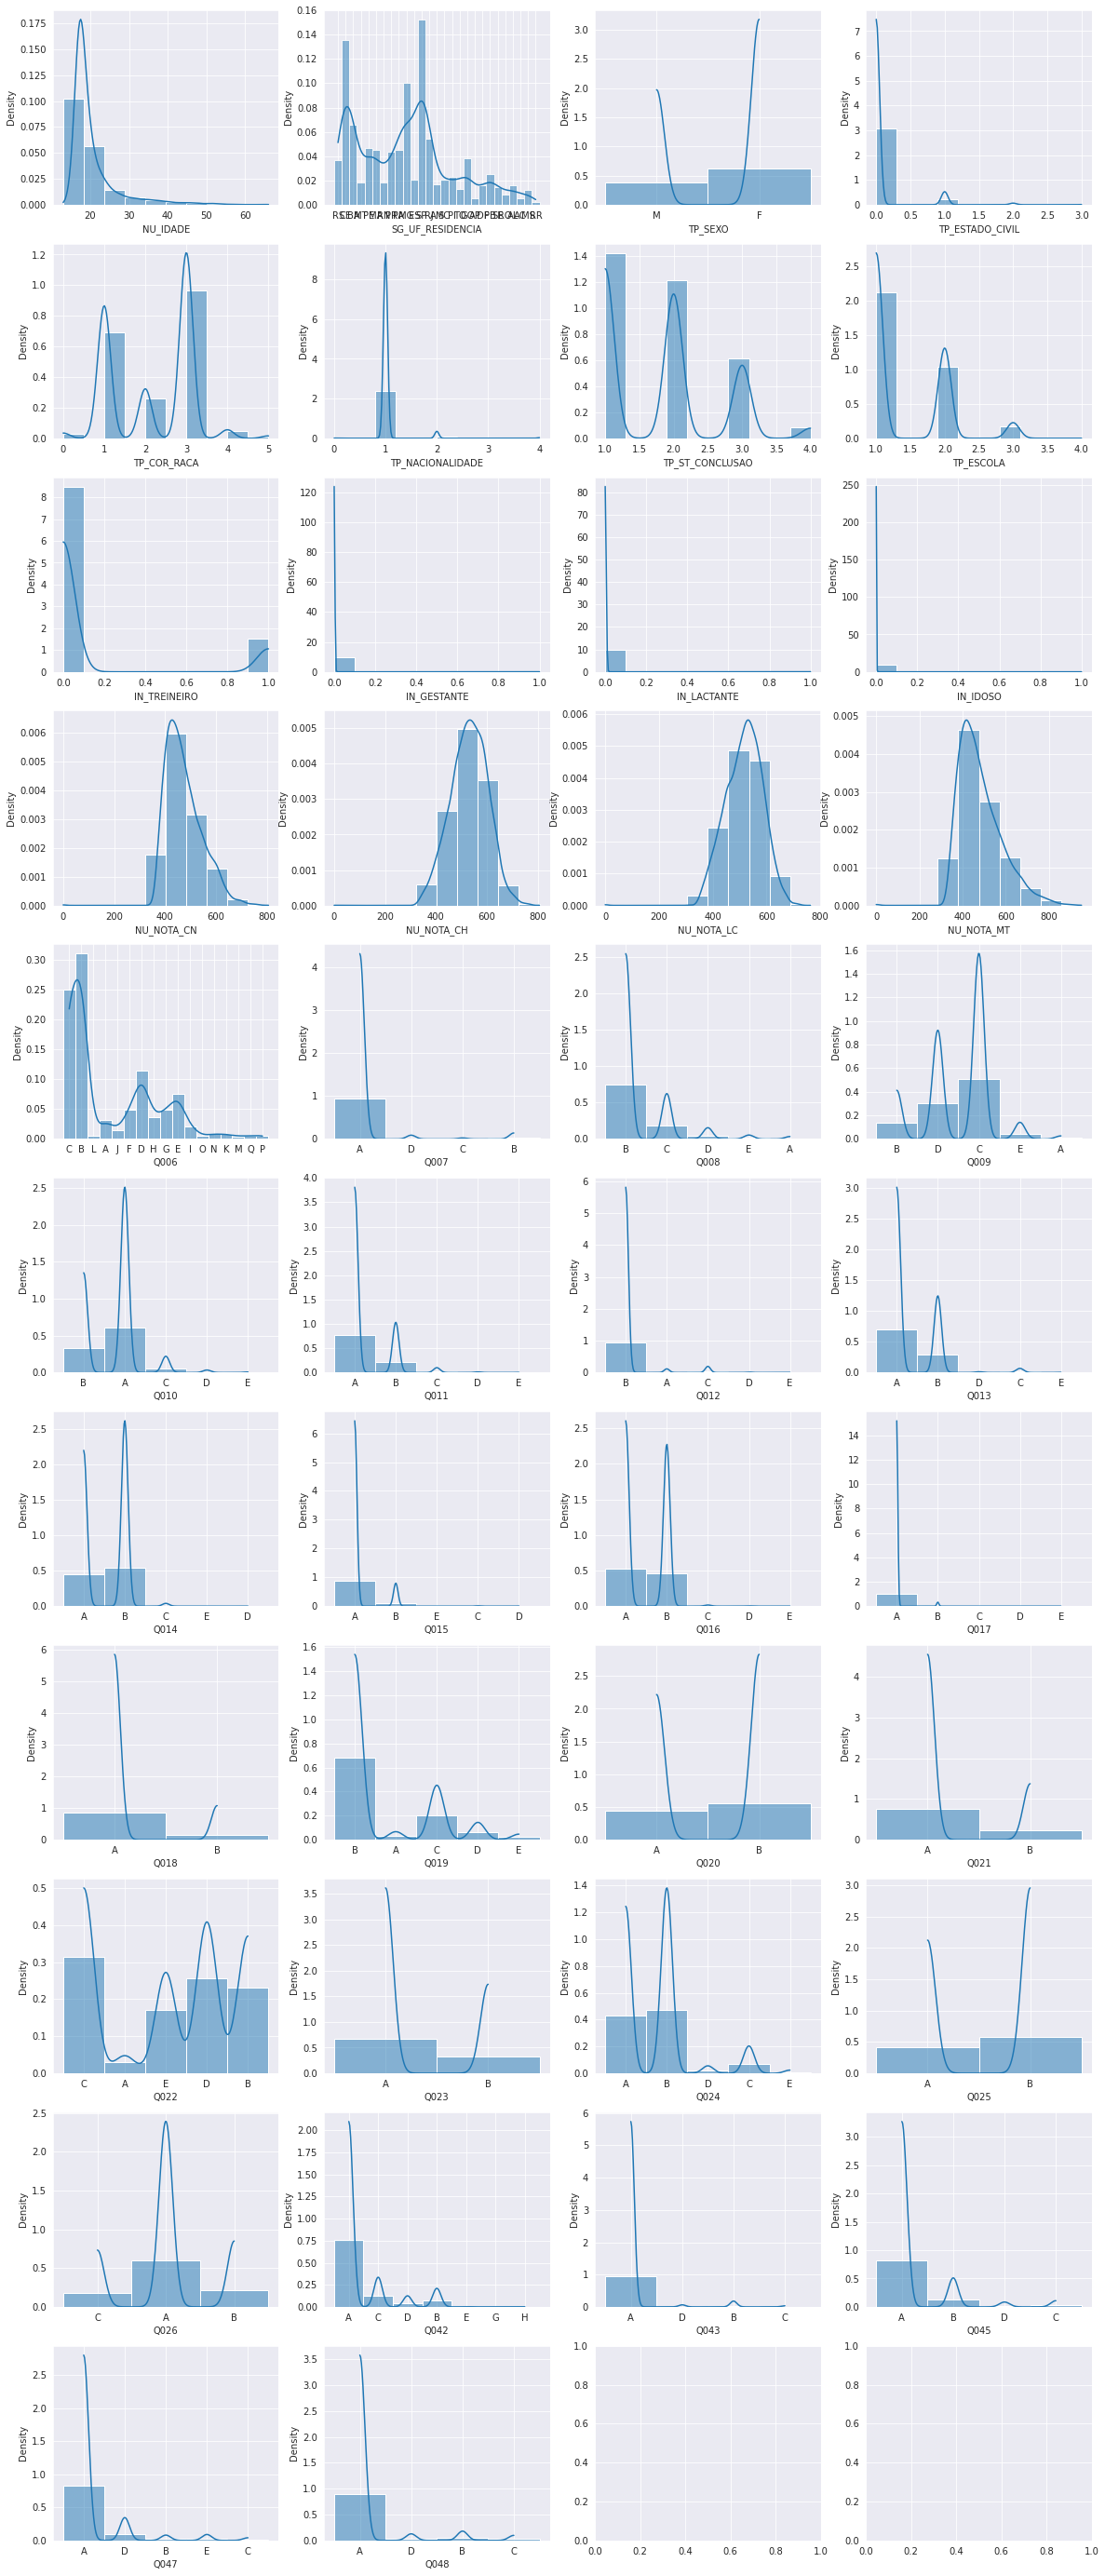

In [186]:
fig, axes = plt.subplots(nrows = 11, ncols = 4)
fig.set_size_inches(20,50)

for i, col in enumerate(selected_feat_eda):
  sns.histplot(df[col], ax = axes[i//4,i%4], bins= 10, stat='density', kde=True)

/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


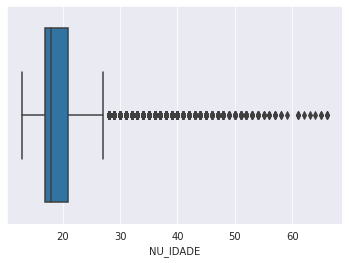

In [187]:
sns.boxplot(df['NU_IDADE'])

In [188]:
def z_score_remove(df,col):
  z = np.abs(stats.zscore(df[col]))
  return df[(z < 2)], df[(z >= 2)]

In [189]:
df1, df2 = z_score_remove(df, 'NU_IDADE')

In [190]:
df2.shape

(570, 42)

In [191]:
df2['NU_IDADE'].value_counts().index.sort_values()[0]

33

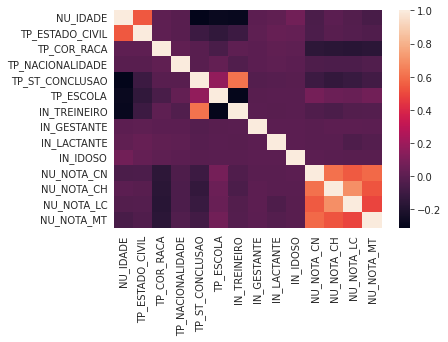

In [192]:
sns.heatmap(df.corr())

In [256]:
df_new = df

## Treino e Teste
Separação em treino e teste

In [193]:
train, test = train_test_split(df, test_size=0.2, random_state=42)
X_train, y_train = train.drop(columns="NU_NOTA_MT"), train["NU_NOTA_MT"]
X_test, y_test = test.drop(columns="NU_NOTA_MT"), test["NU_NOTA_MT"]

In [194]:
print(f'X_train: {X_train.shape}\ny_train: {y_train.shape}\nX_test: {X_test.shape}\ny_test: {y_test.shape}')

X_train: (7824, 41)
y_train: (7824,)
X_test: (1957, 41)
y_test: (1957,)


## Transformação de features
Seleção de features categóricas e features numéricas.

In [195]:
train.head()

,NU_IDADE,SG_UF_RESIDENCIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,IN_GESTANTE,...,Q022,Q023,Q024,Q025,Q026,Q042,Q043,Q045,Q047,Q048
6159,17,SP,F,0.0,3,1,2,2,0,0,...,E,A,B,B,A,A,A,A,A,A
832,17,SC,M,0.0,1,1,3,1,1,0,...,D,A,A,A,A,A,A,A,A,A
3144,21,PR,F,0.0,1,1,1,1,0,0,...,C,B,B,B,B,A,A,A,A,D
12251,18,SP,M,0.0,3,1,2,2,0,0,...,C,A,B,B,B,B,A,A,A,A
10379,20,RJ,M,0.0,2,1,2,2,0,0,...,C,A,B,A,A,B,B,B,B,A


#### Agrupamento de features
As features serão agrupadas em 03 grupos:

1.   Variáveis numéricas: a transformação dessas variáveis será realizada com Z-scale
2.   Variáveis categóricas 01: a transformação dessas variáveis será realizada com Ordinal Enconder
3.   Variáveis categóricas 02: a transformação dessas variáveis será realizada com OneHot Enconder.



In [196]:
feat_num = ['NU_IDADE', 'NU_NOTA_MT', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
feat_cat1 = ['TP_SEXO', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q042', 'Q043', 'Q045', 'Q047', 'Q048']
feat_cat2 = ['SG_UF_RESIDENCIA', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO']

#### Variáveis numéricas
Para as variáveis numéricas, será utilizada a transformação Z-scale.

In [197]:
z_score = StandardScaler()
def std_z_scale(df,col):
  df[col] = z_score.fit_transform(df[[col]])

In [198]:
for col in feat_num:
  std_z_scale(train, col)
  std_z_scale(test, col)

In [199]:
train[feat_num].head()

,NU_IDADE,NU_NOTA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC
6159,-0.550652,-0.510703,-0.436235,0.399796,0.611984
832,-0.550652,-0.579906,-0.067091,-0.083269,-0.366792
3144,0.097018,2.152098,1.031917,1.001581,0.230699
12251,-0.388735,-0.554832,0.259944,0.702735,0.708400
10379,-0.064899,-0.540791,-0.700109,0.135066,0.306664


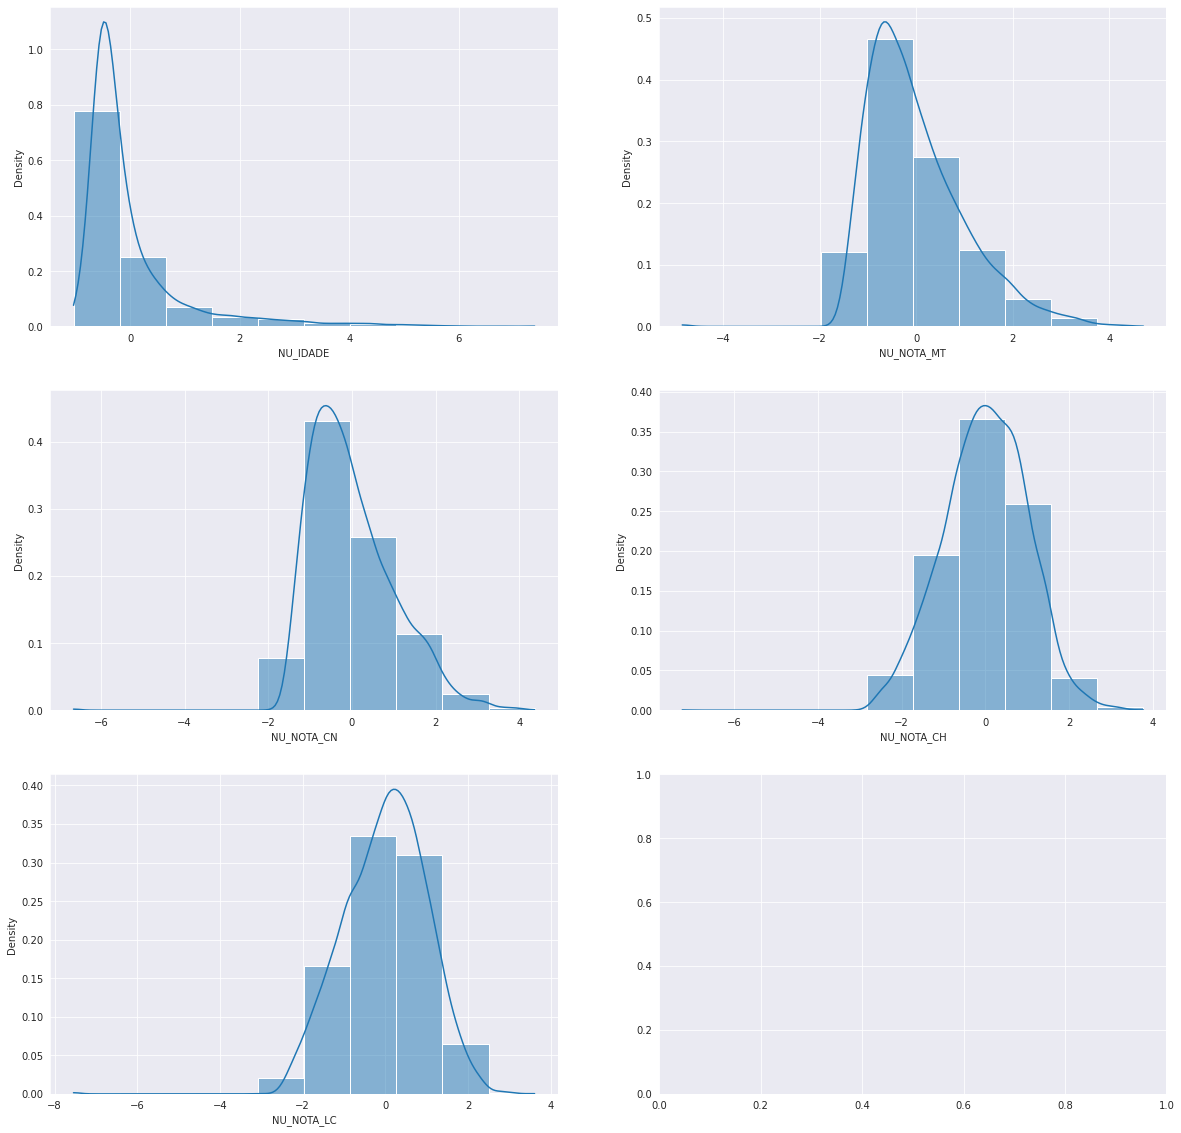

In [200]:
fig, axes = plt.subplots(nrows = 3, ncols = 2)
fig.set_size_inches(20,20)

for i, col in enumerate(feat_num):
  sns.histplot(train[col], ax = axes[i//2,i%2], bins= 10, stat='density', kde=True)

In [201]:
train.shape

(7824, 42)

#### Variáveis categóricas
Devido o formato dos dados, serão adotados modelos de transformações distintos para atender cada variável. Serão utilizadas as transformações OneHot Encoder e Ordinal Encoder.

In [202]:
#Ordinal Encoder
oe = OrdinalEncoder()

maplist = [{'mapping': {'A':1,'B':2,'C':3,'D':4,'E':5,'F':6,'G':7,'H':8,'I':9,'J':10,'K':11,'L':12,'M':13,'N':14,'O':15,'P':16,'Q':17}}]

def ordinal_encoder(df):
  df[feat_cat1] = oe.fit_transform(df[feat_cat1])

In [203]:
ordinal_encoder(train)
ordinal_encoder(test)

In [204]:
train.shape

(7824, 42)

In [205]:
train[feat_cat1].head()

,TP_SEXO,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,...,Q022,Q023,Q024,Q025,Q026,Q042,Q043,Q045,Q047,Q048
6159,1,1,1,1,1,1,1,1,1,1,...,1,1,1,1,1,1,1,1,1,1
832,2,2,1,1,2,1,2,1,2,1,...,2,1,2,2,1,1,1,1,1,1
3144,1,1,1,1,3,1,2,1,1,2,...,3,2,1,1,2,1,1,1,1,2
12251,2,3,1,2,3,2,2,1,1,2,...,3,1,1,1,2,2,1,1,1,1
10379,2,1,1,1,2,1,2,1,2,1,...,3,1,1,2,1,2,2,2,2,1


In [206]:
#OneHot Encoder
one_hot = OneHotEncoder()

for col in feat_cat2:
  temp = pd.DataFrame(one_hot.fit_transform(train[[col]]).toarray(),columns=one_hot.get_feature_names([col]))
  train = train.drop(columns=col).join(temp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [207]:
for col in feat_cat2:
  temp = pd.DataFrame(one_hot.fit_transform(test[[col]]).toarray(),columns=one_hot.get_feature_names([col]))
  test = test.drop(columns=col).join(temp)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is deprecated in 1.0 and will be removed in 1.2. Please use get_feature_names_out instead.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function get_feature_names is deprecated; get_feature_names is d

In [208]:
train.head()

,NU_IDADE,TP_SEXO,TP_ESCOLA,IN_TREINEIRO,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,...,TP_COR_RACA_5,TP_NACIONALIDADE_0,TP_NACIONALIDADE_1,TP_NACIONALIDADE_2,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4,TP_ST_CONCLUSAO_1,TP_ST_CONCLUSAO_2,TP_ST_CONCLUSAO_3,TP_ST_CONCLUSAO_4
6159,-0.550652,1,2,0,0,0,0,-0.436235,0.399796,0.611984,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
832,-0.550652,2,1,1,0,0,0,-0.067091,-0.083269,-0.366792,...,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3144,0.097018,1,1,0,0,0,0,1.031917,1.001581,0.230699,...,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
12251,-0.388735,2,2,0,0,0,0,0.259944,0.702735,0.708400,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
10379,-0.064899,2,2,0,0,0,0,-0.700109,0.135066,0.306664,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN


In [209]:
train.shape

(7824, 83)

In [210]:
test.shape

(1957, 83)

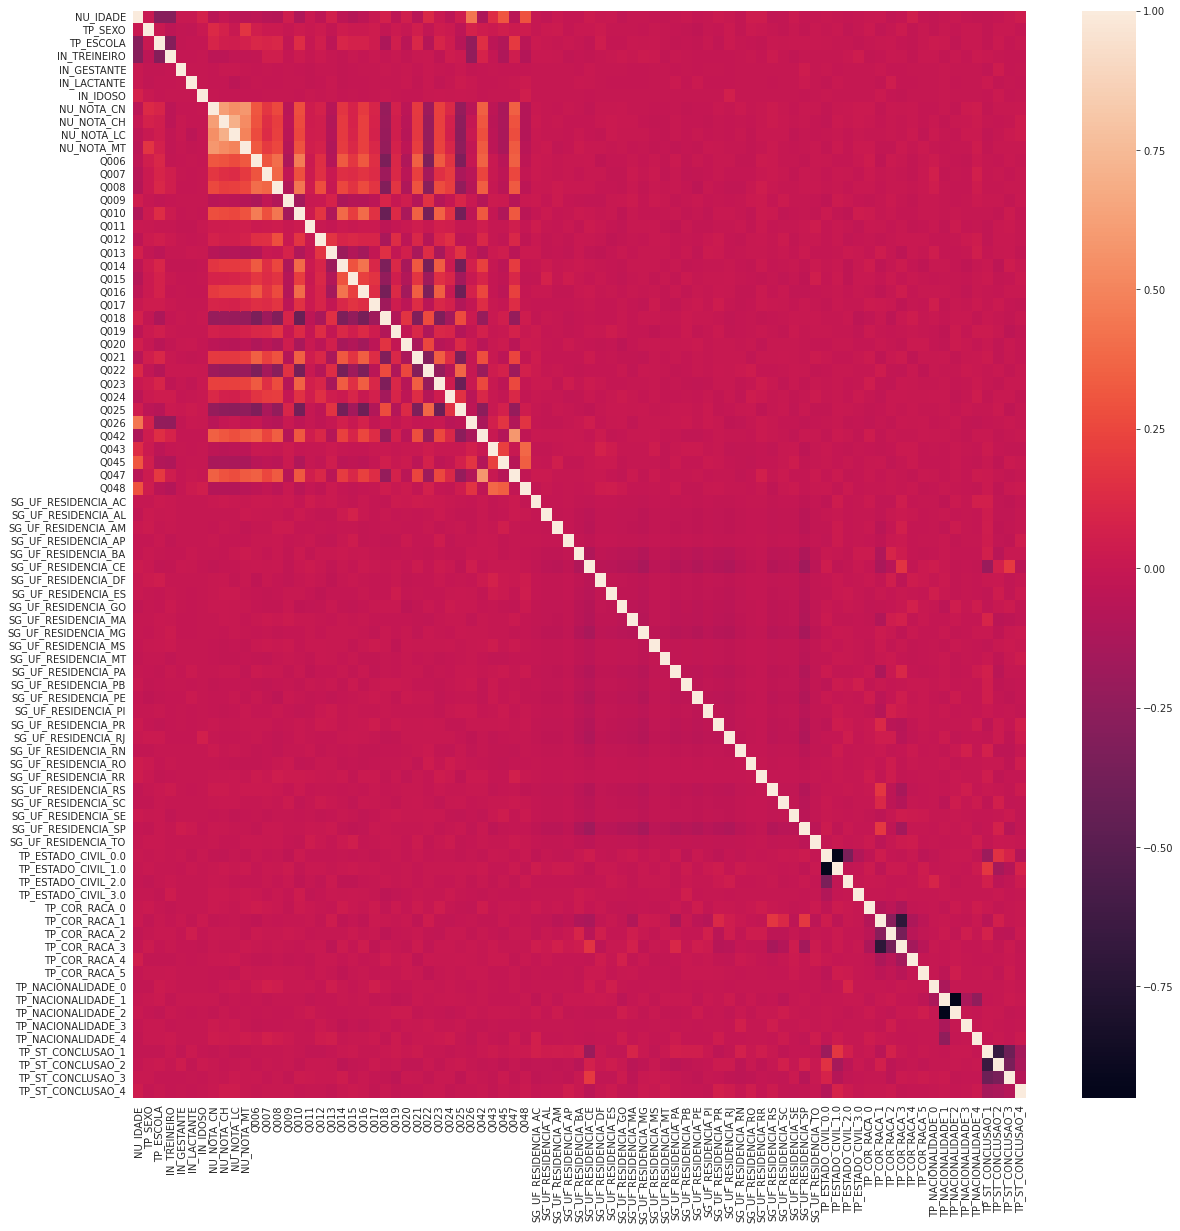

In [211]:
plt.figure(figsize=(20,20))
sns.heatmap(train.corr())

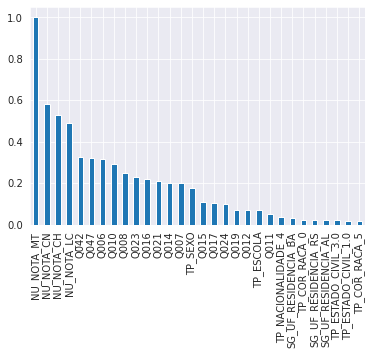

In [212]:
train.corr()['NU_NOTA_MT'].sort_values(ascending=False).head(30).plot(kind='bar')

In [213]:
train.isna().sum()

NU_IDADE                 0
TP_SEXO                  0
TP_ESCOLA                0
IN_TREINEIRO             0
IN_GESTANTE              0
                      ... 
TP_NACIONALIDADE_4    3390
TP_ST_CONCLUSAO_1     3390
TP_ST_CONCLUSAO_2     3390
TP_ST_CONCLUSAO_3     3390
TP_ST_CONCLUSAO_4     3390
Length: 83, dtype: int64

In [214]:
for col in train.columns:
  train[col].fillna(train[col].median(), inplace=True)
  test[col].fillna(test[col].median(), inplace=True)

## Selecionando as melhores features

1º passo: Saber quantas features você irá selecionar

In [215]:
df_features = train.drop(columns='NU_NOTA_MT')
df_target = train['NU_NOTA_MT']

In [216]:
# Selecionando todas as features para retornar o score
fs = SelectKBest(score_func=f_classif, k='all')
fs.fit(df_features,df_target)

SelectKBest(k='all')

In [217]:
# como o resultado é em array, converter para dataframe
scores = pd.DataFrame(data=fs.scores_, columns=['score'])
scores.sort_values(by='score', ascending=False, inplace=True)
scores.reset_index(inplace=True)
scores

,index,score
0,76,7.597984
1,7,2.611149
2,66,2.387538
3,77,2.016121
4,11,1.854749
...,...,...
77,65,0.843259
78,32,0.838345
79,60,0.817267
80,73,0.797911


In [218]:
scores = scores.sort_values(by='index')
scores['FEATURE'] = train.drop(columns='NU_NOTA_MT').columns
scores.sort_values(by='score', ascending=False, inplace=True)

In [219]:
scores

,index,score,FEATURE
0,76,7.597984,TP_NACIONALIDADE_3
1,7,2.611149,NU_NOTA_CN
2,66,2.387538,TP_ESTADO_CIVIL_3.0
3,77,2.016121,TP_NACIONALIDADE_4
4,11,1.854749,Q007
...,...,...,...
77,65,0.843259,TP_ESTADO_CIVIL_2.0
78,32,0.838345,Q043
79,60,0.817267,SG_UF_RESIDENCIA_SE
80,73,0.797911,TP_NACIONALIDADE_0


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


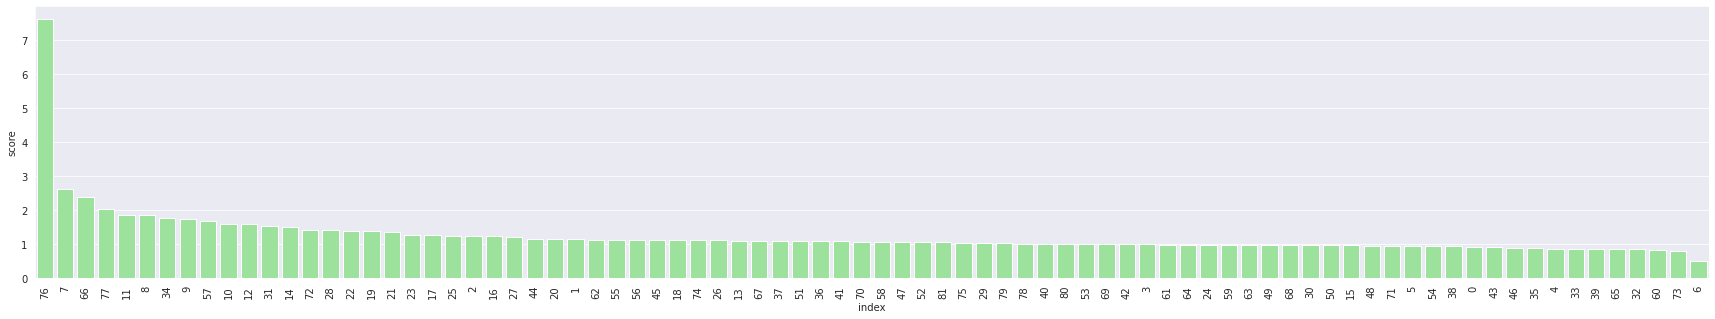

In [149]:
plt.figure(figsize=(30,5))
sns.barplot(scores['index'], scores.score,  order=scores['index'], color='lightgreen')
plt.xticks(rotation=90)
plt.show()

In [220]:
#Aqui fica definida a quantidade de features que seguem na análise
scores_select = scores[scores['index'].isin(np.where(fs.pvalues_>0.05)[0])]
score_qttd = scores_select.shape[0]
print(f"Foram selecionadas {score_qttd} features de {train.shape[1]}.")

Foram selecionadas 38 features de 83.


In [221]:
# Definida a quantidade de features, o SelectKBest pode ser rodado novamente
fs = SelectKBest(score_func=f_classif, k=score_qttd)
fs.fit(df_features,df_target)

cols = fs.get_support(indices=True)
df_features_new = df_features.iloc[:,cols]

train_fs = pd.DataFrame(fs.transform(df_features))

In [222]:
select_columns = []
for col in df_features_new.columns:
  select_columns.append(col)

In [223]:
train = train[select_columns]

In [224]:
train.shape

(7824, 38)

In [225]:
train.head()

,TP_SEXO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,Q006,Q007,Q008,Q009,Q010,...,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_TO,TP_ESTADO_CIVIL_3.0,TP_COR_RACA_0,TP_COR_RACA_5,TP_NACIONALIDADE_1,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4
6159,1,2,-0.436235,0.399796,0.611984,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
832,2,1,-0.067091,-0.083269,-0.366792,2,1,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3144,1,1,1.031917,1.001581,0.230699,1,1,1,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12251,2,2,0.259944,0.702735,0.708400,3,1,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10379,2,2,-0.700109,0.135066,0.306664,1,1,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [226]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7824 entries, 6159 to 10228
Data columns (total 38 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   TP_SEXO              7824 non-null   int64  
 1   TP_ESCOLA            7824 non-null   int64  
 2   NU_NOTA_CN           7824 non-null   float64
 3   NU_NOTA_CH           7824 non-null   float64
 4   NU_NOTA_LC           7824 non-null   float64
 5   Q006                 7824 non-null   int64  
 6   Q007                 7824 non-null   int64  
 7   Q008                 7824 non-null   int64  
 8   Q009                 7824 non-null   int64  
 9   Q010                 7824 non-null   int64  
 10  Q012                 7824 non-null   int64  
 11  Q013                 7824 non-null   int64  
 12  Q014                 7824 non-null   int64  
 13  Q015                 7824 non-null   int64  
 14  Q016                 7824 non-null   int64  
 15  Q017                 7824 non-null

In [ ]:
#train.drop(columns = ['IN_GESTANTE', 'SG_UF_RESIDENCIA_DF', 'SG_UF_RESIDENCIA_MS', 'SG_UF_RESIDENCIA_RO', 'SG_UF_RESIDENCIA_RR', 'SG_UF_RESIDENCIA_SC', 'SG_UF_RESIDENCIA_SE', 'SG_UF_RESIDENCIA_SP', 'TP_NACIONALIDADE_1', 'TP_NACIONALIDADE_2', 'TP_ESTADO_CIVIL_1.0', 'TP_COR_RACA_4'], inplace = True)

In [227]:
train.head()

,TP_SEXO,TP_ESCOLA,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,Q006,Q007,Q008,Q009,Q010,...,SG_UF_RESIDENCIA_RN,SG_UF_RESIDENCIA_RO,SG_UF_RESIDENCIA_RR,SG_UF_RESIDENCIA_TO,TP_ESTADO_CIVIL_3.0,TP_COR_RACA_0,TP_COR_RACA_5,TP_NACIONALIDADE_1,TP_NACIONALIDADE_3,TP_NACIONALIDADE_4
6159,1,2,-0.436235,0.399796,0.611984,1,1,1,1,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
832,2,1,-0.067091,-0.083269,-0.366792,2,1,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
3144,1,1,1.031917,1.001581,0.230699,1,1,1,3,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
12251,2,2,0.259944,0.702735,0.708400,3,1,2,3,2,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0
10379,2,2,-0.700109,0.135066,0.306664,1,1,1,2,1,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0


In [228]:
feat_final = []
for col in train.columns:
  feat_final.append(col)

In [229]:
test = test[feat_final]

In [230]:
test.shape

(1957, 38)

## Machine Learning Model

In [231]:
rfr = RandomForestRegressor()
print(rfr)

parameters = {
    "n_estimators":[10, 50, 100, 250],
    "max_depth":[8, 10, 12]
}

RandomForestRegressor()


In [232]:
cv = GridSearchCV(rfr,parameters,cv=5)

In [235]:
cv.fit(train,y_train.values.ravel())

GridSearchCV(cv=5, estimator=RandomForestRegressor(),
             param_grid={'max_depth': [8, 10, 12],
                         'n_estimators': [10, 50, 100, 250]})

In [236]:
def display(results):
    print(f'Best parameters are: {results.best_params_}')
    print("\n")
    mean_score = results.cv_results_['mean_test_score']
    std_score = results.cv_results_['std_test_score']
    params = results.cv_results_['params']
    for mean,std,params in zip(mean_score,std_score,params):
        print(f'{round(mean,3)} + or -{round(std,3)} for the {params}')

In [237]:
display(cv)

Best parameters are: {'max_depth': 8, 'n_estimators': 100}


0.451 + or -0.035 for the {'max_depth': 8, 'n_estimators': 10}
0.464 + or -0.031 for the {'max_depth': 8, 'n_estimators': 50}
0.465 + or -0.031 for the {'max_depth': 8, 'n_estimators': 100}
0.464 + or -0.032 for the {'max_depth': 8, 'n_estimators': 250}
0.443 + or -0.037 for the {'max_depth': 10, 'n_estimators': 10}
0.459 + or -0.033 for the {'max_depth': 10, 'n_estimators': 50}
0.46 + or -0.032 for the {'max_depth': 10, 'n_estimators': 100}
0.462 + or -0.032 for the {'max_depth': 10, 'n_estimators': 250}
0.429 + or -0.031 for the {'max_depth': 12, 'n_estimators': 10}
0.455 + or -0.033 for the {'max_depth': 12, 'n_estimators': 50}
0.459 + or -0.032 for the {'max_depth': 12, 'n_estimators': 100}
0.46 + or -0.032 for the {'max_depth': 12, 'n_estimators': 250}


In [239]:
y_pred = cv.predict(test)

In [240]:
rmse_test = mean_squared_error(y_test, y_pred)**(1/2)

In [241]:
print(rmse_test)

73.26502063842726


In [253]:
y_test= y_test[y_test>100]

In [252]:
y_pred = y_pred[y_pred>100]

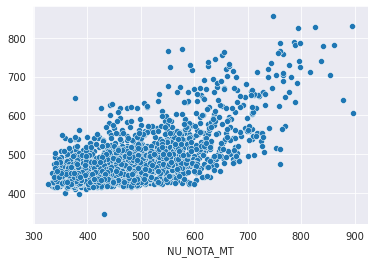

In [254]:
sns.scatterplot(x=y_test, y=y_pred)

plt.show()

## Criando Pipeline

In [ ]:
target = ['NU_NOTA_MT']

In [ ]:
df_new = df

In [ ]:
df_new.head()       

,NU_IDADE,SG_UF_RESIDENCIA,TP_SEXO,TP_ESTADO_CIVIL,TP_COR_RACA,TP_NACIONALIDADE,TP_ST_CONCLUSAO,TP_ESCOLA,IN_TREINEIRO,IN_GESTANTE,IN_LACTANTE,IN_IDOSO,TP_PRESENCA_MT,NU_NOTA_CN,NU_NOTA_CH,NU_NOTA_LC,NU_NOTA_MT,Q006,Q007,Q008,Q009,Q010,Q011,Q012,Q013,Q014,Q015,Q016,Q017,Q018,Q019,Q020,Q021,Q022,Q023,Q024,Q025,Q026,Q042,Q043,Q045,Q047,Q048,IN
0,24,RS,M,0.0,1,1,1,1,0,0,0,0,1,436.3,495.4,581.2,399.4,C,A,B,B,B,A,B,A,A,A,A,A,A,B,A,A,C,A,A,A,C,A,A,A,A,A,0
1,17,CE,F,0.0,3,1,2,2,0,0,0,0,1,474.5,544.1,599.0,459.8,B,A,B,B,A,A,B,A,A,A,A,A,A,B,A,A,A,A,A,A,A,A,A,A,A,A,0
5,18,BA,F,0.0,1,1,1,1,0,0,0,0,1,439.7,583.2,410.9,364.5,C,A,C,D,B,B,B,B,A,A,B,A,A,B,B,B,E,A,B,B,A,A,A,A,A,A,0
6,18,MT,F,0.0,3,1,2,2,0,0,0,0,1,420.1,604.2,484.5,529.2,C,A,C,D,C,A,B,A,B,A,B,A,B,A,A,A,D,A,B,B,C,A,A,B,A,A,0
7,18,RS,F,0.0,1,1,1,1,0,0,0,0,1,619.6,625.8,611.2,566.7,L,A,C,D,B,A,B,B,B,A,B,A,B,C,B,B,D,B,B,B,A,C,A,A,D,A,0


In [ ]:
train, test = train_test_split(df_new, test_size=0.2, random_state=42)
X_train, y_train = train.drop(columns='NU_NOTA_MT'), train[target]
X_test, y_test = test.drop(columns='NU_NOTA_MT'), test[target]

In [ ]:
z_score = StandardScaler()
oe = OrdinalEncoder()
one_hot = OneHotEncoder()

In [ ]:
feat_num = ['NU_IDADE', 'NU_NOTA_CN', 'NU_NOTA_CH', 'NU_NOTA_LC']
feat_cat1 = ['TP_SEXO', 'Q006', 'Q007', 'Q008', 'Q009', 'Q010', 'Q011', 'Q012', 'Q013', 'Q014', 'Q015', 'Q016', 'Q017', 'Q018', 'Q019', 'Q020', 'Q021', 'Q022', 'Q023', 'Q024', 'Q025', 'Q026', 'Q042', 'Q043', 'Q045', 'Q047', 'Q048', 'IN']
feat_cat2 = ['SG_UF_RESIDENCIA', 'TP_ESTADO_CIVIL', 'TP_COR_RACA', 'TP_NACIONALIDADE', 'TP_ST_CONCLUSAO']

In [ ]:
preprocess = ColumnTransformer(
                    [   
                        ('StdTransf', z_score, feat_num),
                        ('Ordinal', oe, feat_cat1),
                        ('OneHot', one_hot, feat_cat2),
                        
                    ], remainder='passthrough')

In [ ]:
dt_tf = preprocess.fit_transform(X_train, y_train)

In [ ]:
pd.DataFrame(data = dt_tf).head()

,0,1,2,3,4,5,6,7,8,9,10,11,12,13,14,15,16,17,18,19,20,21,22,23,24,25,26,27,28,29,30,31,32,33,34,35,36,37,38,39,...,44,45,46,47,48,49,50,51,52,53,54,55,56,57,58,59,60,61,62,63,64,65,66,67,68,69,70,71,72,73,74,75,76,77,78,79,80,81,82,83
0,-0.550652,-0.436235,0.399796,0.611984,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
1,-0.550652,-0.067091,-0.083269,-0.366792,2.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,2.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0
2,0.097018,1.031917,1.001581,0.230699,1.0,1.0,1.0,1.0,3.0,1.0,2.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,2.0,2.0,1.0,3.0,2.0,1.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0
3,-0.388735,0.259944,0.702735,0.708400,2.0,3.0,1.0,2.0,3.0,2.0,2.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,1.0,3.0,1.0,1.0,1.0,2.0,2.0,1.0,1.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0
4,-0.064899,-0.700109,0.135066,0.306664,2.0,1.0,1.0,1.0,2.0,1.0,2.0,1.0,2.0,1.0,1.0,1.0,1.0,2.0,2.0,2.0,1.0,3.0,1.0,1.0,2.0,1.0,2.0,2.0,2.0,2.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,2.0,0.0,0.0,0.0,0.0,1.0


In [ ]:
model = TransformedTargetRegressor(regressor=RandomForestRegressor(n_estimators=250, bootstrap=True, criterion='mse', max_depth=8, max_features='auto', random_state=42), transformer = z_score)

In [ ]:
pipe = Pipeline([("pre", preprocess), ("tree", model)])
pipe.fit(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/ensemble/_forest.py:400: FutureWarning: Criterion 'mse' was deprecated in v1.0 and will be removed in version 1.2. Use `criterion='squared_error'` which is equivalent.
  FutureWarning,


Pipeline(steps=[('pre',
                 ColumnTransformer(remainder='passthrough',
                                   transformers=[('StdTransf', StandardScaler(),
                                                  ['NU_IDADE', 'NU_NOTA_CN',
                                                   'NU_NOTA_CH',
                                                   'NU_NOTA_LC']),
                                                 ('Ordinal', OrdinalEncoder(),
                                                  ['TP_SEXO', 'Q006', 'Q007',
                                                   'Q008', 'Q009', 'Q010',
                                                   'Q011', 'Q012', 'Q013',
                                                   'Q014', 'Q015', 'Q016',
                                                   'Q017', 'Q018', 'Q019',
                                                   'Q020', 'Q021', 'Q022',
                                                   'Q023', 'Q024', 'Q025',
                   

In [ ]:
## Test
pred_value = pipe.predict(X_test)

rmse_dt = mean_squared_error(y_test, pred_value) ** (1/2)

print("Test set RMSE of dt: {:.3f}".format(rmse_dt))
print(f"Test set R2 of dt {r2_score(y_test, pred_value):.3f}")

Test set MSE of dt: 5308.096
Test set RMSE of dt: 72.857
Test set R2 of dt 0.466


### Gerando arquivo .pkl

In [ ]:
pk.dump(pipe, open('model_rfr.pkl', 'wb'))